# Training for Image Classification

In this workbook, we will look into an image classification problem. The dataset contains several images of the plant leaves with 7 categories of *diseases* and we would like to classify them accordingly. A total of 13,878 samples are provided. While the samples are lesser, we shall explore data augmentation or pre-training later in the workbook to improve training. We will first load the data from [CyVerse Data Store](https://cyverse.org/data-store) where we have hosted the dataset for this tutorial. 

# 1. Downloading the data and setting it up

First, we need to download the dataset which is stored in `/iplant/home/shared/soynomics/trac_train_april_2022/plant-disease-detection.zip`. 

In [1]:
! iget -fPT /iplant/home/shared/soynomics/trac_train_april_2022/leaf-detection-images-small-set.tar.gz
! iget -fPT /iplant/home/shared/soynomics/trac_train_april_2022/leaf-disease-detection.npz

0/1 -  0.00% of files done   0.000/2756.038 MB -  0.00% of file sizes done
Processing leaf-detection-images-small-set.tar.gz - 2756.038 MB   2022-04-09.06:04:47
leaf-detection-images-small-set.tar.gz - 640.000/2756.038 MB - 23.22% done   2022-04-09.06:04:52
leaf-detection-images-small-set.tar.gz - 1360.000/2756.038 MB - 49.35% done   2022-04-09.06:04:54
leaf-detection-images-small-set.tar.gz - 2064.505/2756.038 MB - 74.91% done   2022-04-09.06:04:57
leaf-detection-images-small-set.tar.gz - 2667.028/2756.038 MB - 96.77% done   2022-04-09.06:04:57
leaf-detection-images-small-set.tar.gz - 2743.785/2756.038 MB - 99.56% done   2022-04-09.06:04:58
leaf-detection-images-small-set.tar.gz - 2756.038/2756.038 MB - 100.00% done   2022-04-09.06:04:58
0/1 -  0.00% of files done   0.000/563.932 MB -  0.00% of file sizes done
Processing leaf-disease-detection.npz - 563.932 MB   2022-04-09.06:05:01
leaf-disease-detection.npz - 240.000/563.932 MB - 42.56% done   2022-04-09.06:05:03
leaf-disease-detecti

In [2]:
# needs to install sudo apt-get install fastjar
! tar xvf  leaf-detection-images-small-set.tar.gz

Leaf_Images/
Leaf_Images/1/
Leaf_Images/1/output/
Leaf_Images/1/output/IMG_1513_view.JPG-1.png
Leaf_Images/1/output/IMG_1513_view.JPG-2.png
Leaf_Images/1/output/IMG_1513_view.JPG-3.png
Leaf_Images/1/output/IMG_1513_view.JPG-4.png
Leaf_Images/1/output/IMG_1517_view.JPG-1.png
Leaf_Images/1/output/IMG_1517_view.JPG-2.png
Leaf_Images/1/output/IMG_1517_view.JPG-3.png
Leaf_Images/1/output/IMG_1517_view.JPG-4.png
Leaf_Images/1/output/IMG_1518_view.JPG-1.png
Leaf_Images/1/output/IMG_1518_view.JPG-2.png
Leaf_Images/1/output/IMG_1518_view.JPG-3.png
Leaf_Images/1/output/IMG_1518_view.JPG-4.png
Leaf_Images/1/output/IMG_1558_view.JPG-1.png
Leaf_Images/1/output/IMG_1558_view.JPG-2.png
Leaf_Images/1/output/IMG_1558_view.JPG-3.png
Leaf_Images/1/output/IMG_1558_view.JPG-4.png
Leaf_Images/1/output/IMG_1559_view.JPG-1.png
Leaf_Images/1/output/IMG_1559_view.JPG-2.png
Leaf_Images/1/output/IMG_1559_view.JPG-3.png
Leaf_Images/1/output/IMG_1559_view.JPG-4.png
Leaf_Images/1/output/IMG_1560_view.JPG-1.png
Leaf_

In [3]:
rm leaf-detection-images-small-set.tar.gz

# 2. Imports and Dependencies.
The few packages needed are loaded next. Paricularly, `torch`, `matplotlib`, `numpy`, `cv2`, `torchvision`

In [4]:
#Import  native python packages
import os
import math
import copy
import json
import random
import zipfile

#Import  non-deep learning package
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
from sklearn.feature_extraction.image import extract_patches_2d


import torch
import pytorch_lightning as pl
import torchvision
import torchvision.transforms as transforms

from torchvision import datasets
from torchvision.utils import make_grid
import torchmetrics
from torchmetrics import ConfusionMatrix

In [5]:
def crop_to_center(old_img, new_img):
 
    if isinstance(old_img, tuple):
        original_shape = old_img
    else:
        original_shape = old_img.shape
    original_width = original_shape[1]
    original_height = original_shape[0]
    original_center_x = original_shape[1] / 2
    original_center_y = original_shape[0] / 2

    new_width = new_img.shape[1]
    new_height = new_img.shape[0]
    new_center_x = new_img.shape[1] / 2
    new_center_y = new_img.shape[0] / 2

    new_left_x = int(max(new_center_x - original_width / 2, 0))
    new_right_x = int(min(new_center_x + original_width / 2, new_width))
    new_top_y = int(max(new_center_y - original_height / 2, 0))
    new_bottom_y = int(min(new_center_y + original_height / 2, new_height))

    # create new img canvas
    canvas = np.zeros(original_shape)

    left_x = int(max(original_center_x - new_width / 2, 0))
    right_x = int(min(original_center_x + new_width / 2, original_width))
    top_y = int(max(original_center_y - new_height / 2, 0))
    bottom_y = int(min(original_center_y + new_height / 2, original_height))

    canvas[top_y:bottom_y, left_x:right_x] = new_img[new_top_y:new_bottom_y, new_left_x:new_right_x]

    return canvas

In [6]:
# Rotate image definition
def rotate_image(image, angle):
    # get dims, find center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    image = warpAffine(image, M, (nW, nH), False)

    # image = cv2.resize(image, (w,h))

    return image

## WarpAffine Definition
def warpAffine(src, M, dsize, from_bounding_box_only=False):

    return cv2.warpAffine(src, M, dsize)


In [7]:
# directory location for the dataset
DATADIR = './Leaf_Images'
categories = ['1', '3', '4', '5', '6', '7', '8']

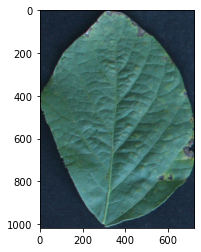

In [8]:
# Visualization of one sample

category_path = os.path.join(DATADIR, categories[0], "output")
img = os.listdir(category_path)[0]

img_array = cv2.imread(os.path.join(category_path, img))
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
plt.imshow(img_array)
plt.show()

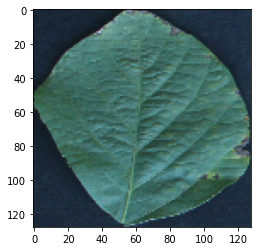

In [10]:
# resizing the image
IMG_SIZE = 128 # choose image size. 
new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # resizing to square image with desired image size
plt.imshow(new_array)
plt.show()

In [11]:
# generating dataset (Image rotating perform)
total_data = []

def create_total_data():
    for class_num, category in enumerate(categories):
        category_path = os.path.join(DATADIR, category, "output")
        print('loading from %s'%category_path)
        for img_name in tqdm(os.listdir(category_path)):
            img_path = os.path.join(category_path, img_name)
            try:
                img_arraybase = cv2.imread(img_path)
                img_arraybase = cv2.cvtColor(img_arraybase, cv2.COLOR_BGR2RGB)

                # img_array = crop_to_center(img_arraybase, rotate_image(img_arraybase, random.randint(1,359)))
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                total_data.append([new_array, class_num])             
            except Exception as e:
                print("%s couldnt be loaded"%img_path)

create_total_data()

print(len(total_data))

loading from ./Leaf_Images/1/output


100%|██████████| 126/126 [00:03<00:00, 33.06it/s]


loading from ./Leaf_Images/3/output


100%|██████████| 274/274 [00:06<00:00, 44.51it/s]


loading from ./Leaf_Images/4/output


100%|██████████| 153/153 [00:03<00:00, 42.12it/s]


loading from ./Leaf_Images/5/output


100%|██████████| 217/217 [00:03<00:00, 66.22it/s]


loading from ./Leaf_Images/6/output


100%|██████████| 700/700 [00:13<00:00, 52.49it/s]


loading from ./Leaf_Images/7/output


100%|██████████| 287/287 [00:11<00:00, 24.76it/s]


loading from ./Leaf_Images/8/output


100%|██████████| 1247/1247 [00:39<00:00, 31.34it/s]

3004


In [15]:
# load the actual large dataset after resizing at this point.

total_data = np.load('leaf-disease-detection.npz', allow_pickle=True)['data']

In [16]:
# Split the data into training, validation and testing (0.6, 0.2, 0.2)
train_size = 0.6
val_size = 0.2
test_size = 0.2

train_data = total_data[:int(len(total_data)*train_size)]
val_data = total_data[int(len(total_data)*train_size):int(len(total_data)*(train_size+val_size))]
test_data = total_data[int(len(total_data)*(train_size+val_size)):]

print(len(train_data), len(val_data), len(test_data))

8302 2767 2768


In [17]:
# free up memory
del total_data

In [18]:
class PlantsDiseaseData(torch.utils.data.Dataset):
    'PyTorch dataset for sampling coefficients'
    def __init__(self, dataset, transforms):
        """
        Initialization
        """
        self.dataset = dataset
        self.n_samples = len(self.dataset)
        self.transforms = transforms

    def __len__(self):
        'Denotes the total number of samples'
        return self.n_samples

    def __getitem__(self, index):
        'Generates one sample of data'
        inputs = self.dataset[index][0]/255.0
        inputs = np.moveaxis(inputs, -1, 0)
        label = self.dataset[index][1]
        return torch.FloatTensor(inputs), label


In [19]:
transform = transforms.Compose([transforms.ToTensor()])
trainDataset = PlantsDiseaseData(train_data, transform)
valDataset = PlantsDiseaseData(val_data, transform)
testDataset = PlantsDiseaseData(test_data, transform)

In [20]:
model = torchvision.models.resnet18(num_classes=len(categories)).float()

In [21]:
class Classifier(pl.LightningModule):
    def __init__(self, network, train_data, val_data, test_data):
        super().__init__()
        self.network = network
        self.train_data = train_data
        self.test_data = test_data
        self.val_data = val_data
        self.criterion = torch.nn.CrossEntropyLoss() 
        self.accuracy = torchmetrics.Accuracy()

    
    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        images, target = batch
        pred = self.forward(images)        
        loss = self.criterion(pred, target)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        images, target = batch
        pred = self.forward(images)
        loss = self.criterion(pred, target)
        self.log("val_loss", loss)
        return loss   

    def test_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        images, target = batch
        pred = self.forward(images)
        loss = self.criterion(pred, target)
        preds = torch.argmax(pred, dim=1)
        acc=self.accuracy(preds,target)
        self.log("test_accuracy", acc)
        self.log("test_loss", loss)
        return {"test_accuracy": acc, "test_loss": loss}
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data,  batch_size=16)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data,  batch_size=16)

    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data,  batch_size=16)
     
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data,  batch_size=16)



In [22]:
pl_model = Classifier(model, trainDataset, valDataset, testDataset)

In [23]:
logger = pl.loggers.TensorBoardLogger('.', name="plant-detection")
csv_logger = pl.loggers.CSVLogger(logger.save_dir, name=logger.name, version=logger.version)

early_stopping = pl.callbacks.early_stopping.EarlyStopping('val_loss',
    min_delta=1e-8, patience=10, verbose=False, mode='max', strict=True)
checkpoint = pl.callbacks.model_checkpoint.ModelCheckpoint(monitor='val_loss',
    dirpath=logger.log_dir, filename='{epoch}-{step}',
    mode='min', save_last=True)

trainer = pl.Trainer(gpus=[0],callbacks=[early_stopping],
        checkpoint_callback=checkpoint, logger=[logger,csv_logger],
        max_epochs=10, profiler='simple')

Missing logger folder: ./plant-detection
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:151: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fdf1d752c70>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fdf1d752c70>)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(pl_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | network   | ResNet           | 11.2 M
1 | criterion | CrossEntropyLoss | 0     
2 | accuracy  | Accuracy         | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.720    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

FIT Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                       

In [25]:
#Test the model. Return metrics and confusion matrix
results = trainer.test()

/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1447: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/jovyan/tractrain2022/notebooks/part-1/training/plant-detection/0/checkpoints/epoch=0-step=519.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/jovyan/tractrain2022/notebooks/part-1/training/plant-detection/0/checkpoints/epoch=0-step=519.ckpt
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argume

Testing: 0it [00:00, ?it/s]

TEST Profiler Report

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                      

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.299855500459671
        test_loss           1.8356860876083374
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
